# Initial Look at Data

In [1]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# specifying path to data folder
folder = "../data/raw/"
# specifying subject
subject = "S1"

In [3]:
# load data 
with open(os.path.join(folder,subject,subject+'.pkl'),'rb') as f:
    # encoding has to be latin1 to avoid a unicodedecodeerror
    data = pickle.load(f,encoding="latin1") 

In [4]:
data

{'rpeaks': array([    240,    1174,    2128, ..., 6447292, 6447748, 6448224],
       dtype=int32),
 'signal': {'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
          [ 0.8556    , -0.06900001, -0.3646    ],
          [ 0.852     , -0.07020003, -0.3642    ],
          ...,
          [ 0.88759995, -0.1038    , -0.27920002],
          [ 0.88619995, -0.10159999, -0.27819997],
          [ 0.88680005, -0.10140002, -0.27380002]]),
   'ECG': array([[0.01560974],
          [0.01812744],
          [0.01753235],
          ...,
          [0.21368408],
          [0.21556091],
          [0.21702576]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
    

The data is saved as a dictionary. According to the data README and the reference paper, the purpose of the dataset is to use the PPG data to determine heart-rate. The PPG data is obtained from a wrist wearable and is provided in data[signal][wrist]. 

The different wrist signals are recorded at different frequencies. Let's investigate the shape of this data

In [5]:
wrist_data = data['signal']['wrist']

In [6]:
# 3D accelerometer data -> recorded at 32 Hz, 3 dimensions for acceleration_x, y and z
wrist_data['ACC'].shape

(294784, 3)

In [7]:
# the actual PPG signal (saved as BVP -> Blood Volume Pulse) -> recorded at 64 Hz
wrist_data['BVP'].shape

(589568, 1)

In [8]:
# Electrodermal activity -> recorded at 4 Hz
wrist_data['EDA'].shape

(36848, 1)

In [9]:
# Skin temperature -> recorded at 4 Hz
wrist_data['TEMP'].shape

(36848, 1)

The data was recorded while several "activities" were performed. This data is saved at 4 Hz frequency. Let's look at the shape

In [10]:
data['activity'].shape

(36848, 1)

The ground truth heart rate was provided from ECG measurements every 2 seconds and is defined as mean instantaneous heart rate over an 8 second segment of the data

In [11]:
data['label'].shape

(4603,)

In [12]:
# the total time recorded for this subject
total_time_recorded_s = data['activity'].shape[0]/4

In [13]:
total_time_recorded_s

9212.0

# Resampling and viz

Because of the vastly differing frequencies of measurement, let's resample the data. Using 4 Hz since it is recommended in the paper

In [14]:
# since the bvp frequency is 64 Hz, choosing every 16th measurement would reduce frequency to 4 Hz
wrist_bvp = wrist_data["BVP"][::16]
wrist_bvp.shape

(36848, 1)

In [15]:
# since the acc frequency is 32 Hz, choosing every 8th measurement would reduce frequency to 4 Hz
wrist_acc = wrist_data["ACC"][::8]
wrist_acc.shape

(36848, 3)

In [16]:
# no resampling needed for temp and eda
wrist_temp = wrist_data["TEMP"]
wrist_temp.shape

(36848, 1)

In [17]:
wrist_eda = wrist_data["EDA"]
wrist_eda.shape

(36848, 1)

In [18]:
# since each label is provided for 2 seconds, we should repeat one label 8 times for 2 seconds
labels = np.repeat(data["label"],8,axis=0)
labels.shape

(36824,)

In [19]:
# the number of data points for labels is slightly less than the number of data points for the wrist measurements
# this could be due to a desync at the end. let's just drop the extra measurements from the end

num_measurements_desync = wrist_eda.shape[0]-labels.shape[0]
num_measurements_desync

24

In [20]:
def cut_data(array,num):
    return array[:-num]

In [21]:
wrist_bvp = cut_data(wrist_bvp,num_measurements_desync)
wrist_acc = cut_data(wrist_acc,num_measurements_desync)
wrist_temp = cut_data(wrist_temp,num_measurements_desync)
wrist_eda = cut_data(wrist_eda,num_measurements_desync)

print(wrist_bvp.shape,wrist_acc.shape,wrist_temp.shape,wrist_eda.shape)

(36824, 1) (36824, 3) (36824, 1) (36824, 1)


In [22]:
# obtaining activities info
activities = cut_data(data['activity'],num_measurements_desync)
activities.shape

(36824, 1)

In [23]:
# let's create a dictionary to hold on to the activity labels as per the data reference

activity_dict = {0:'transient',1:'sitting',2:'stairs',3:'table_soccer',4:'cycling',5:'driving',6:'lunch_break',7:'walking',8:'working'}
activity_dict

{0: 'transient',
 1: 'sitting',
 2: 'stairs',
 3: 'table_soccer',
 4: 'cycling',
 5: 'driving',
 6: 'lunch_break',
 7: 'walking',
 8: 'working'}

In [24]:
# let's create a dataframe to hold all the data and then create plots

df = pd.DataFrame(wrist_bvp)
df.columns = ['bvp']
df['acc_x']=wrist_acc[:,0]
df['acc_y']=wrist_acc[:,1]
df['acc_z']=wrist_acc[:,2]

df['temp_c']=wrist_temp
df['eda_microsec']=wrist_eda
df['activity']=activities

labels = labels.reshape((len(labels),1))
df['heart_rate_bpm']=labels
df.head()

,bvp,acc_x,acc_y,acc_z,temp_c,eda_microsec,activity,heart_rate_bpm
0,7.28,-0.765625,-0.078125,0.671875,32.13,4.722437,0.0,49.611369
1,-11.36,-0.765625,-0.078125,0.671875,32.16,4.728843,0.0,49.611369
2,-51.27,-0.765625,-0.078125,0.671875,32.16,4.718594,0.0,49.611369
3,5.65,-0.750000,-0.078125,0.671875,32.16,4.717312,0.0,49.611369
4,34.34,-0.765625,-0.078125,0.671875,32.16,4.713469,0.0,49.611369


In [25]:
df.shape

(36824, 8)

In [26]:
# create an array to hold time
time = np.linspace(0,df.shape[0]/4,df.shape[0])
len(time)

36824

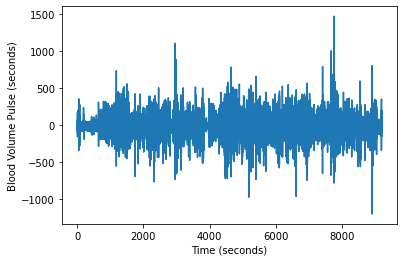

In [27]:
plt.plot(time,df['bvp'])
plt.xlabel('Time (seconds)')
plt.ylabel('Blood Volume Pulse (seconds)')
plt.show();

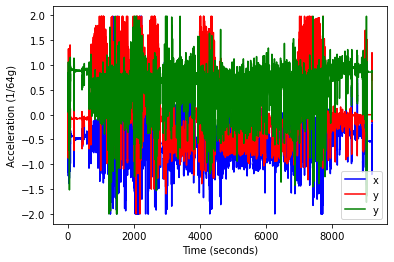

In [28]:
plt.plot(time,df['acc_x'],label='x',color='b')
plt.plot(time,df['acc_y'],label='y',color='r')
plt.plot(time,df['acc_z'],label='y',color='g')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (1/64g)')
plt.legend()
plt.show();

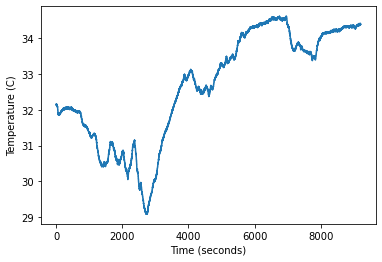

In [29]:
plt.plot(time,df['temp_c'])

plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (C)')
plt.show();

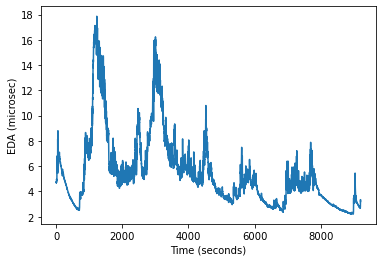

In [30]:
plt.plot(time,df['eda_microsec'])

plt.xlabel('Time (seconds)')
plt.ylabel('EDA (microsec)')
plt.show();

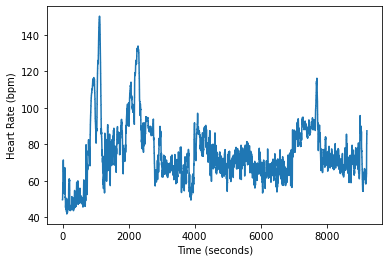

In [31]:
plt.plot(time,df['heart_rate_bpm'])

plt.xlabel('Time (seconds)')
plt.ylabel('Heart Rate (bpm)')
plt.show();

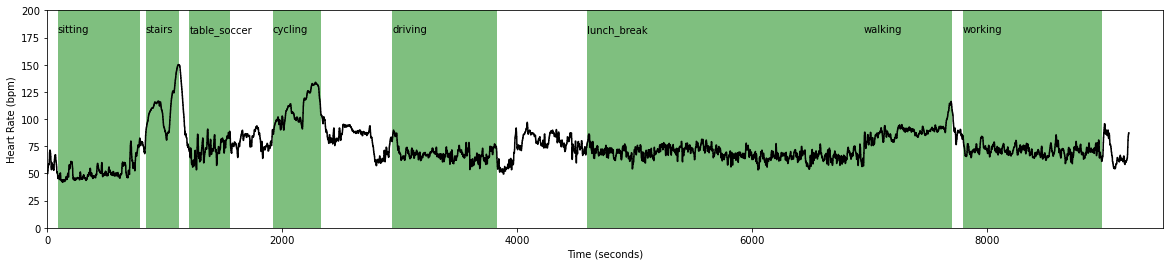

In [32]:
# the heart rate should be a function of the activity, so let's superimpose the activity on this plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time,df['heart_rate_bpm'],'k')
plt.xlim([0,9500])
plt.ylim([0,200])
for i in range(1,9):
    filt = df['activity'] == i
    start_time=df[filt].index[0]/4
    end_time=df[filt].index[-1]/4
    ax.axvspan(start_time,end_time,facecolor="green",alpha=0.5)
    ax.text(start_time,180,activity_dict[i])
    
    
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Heart Rate (bpm)')
plt.show()